In [2]:
!pip install unidecode
!pip install underthesea
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 59.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 52.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 7.5 MB/s eta 0:00:00


In [3]:
import re
import json
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from underthesea import word_tokenize
from unidecode import unidecode
import emoji
import pickle

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Dropout, Bidirectional, LSTM, GlobalMaxPooling1D, LayerNormalization, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model, load_model, save_model

from sklearn.model_selection import train_test_split

In [ ]:
url = "https://shopee.vn/Son-Kem-Black-Rouge-Air-Fit-Velvet-Tint-Ver-2-36.6g-i.182549544.2899625373?sp_atk=b0cfd561-c0f5-45eb-8090-5fbff8ba8cb2&xptdk=b0cfd561-c0f5-45eb-8090-5fbff8ba8cb2"

#get shopid and itemid
r = re.search(r"i\.(\d+)\.(\d+)", url)
shop_id, item_id = r[1], r[2]

ratings_url = "https://shopee.sg/api/v2/item/get_ratings?filter=0&flag=1&itemid={item_id}&limit=20&offset={offset}&shopid={shop_id}&type=0"
offset = 0
d = {"username": [], "rating": [], "comment": []}
i = 1  # Initialize i to 1

while i<=3000:
    data = requests.get(ratings_url.format(shop_id=shop_id, item_id=item_id, offset=offset)).json()

    if data["data"]["ratings"] is not None:
        for rating in data["data"]["ratings"]:
            d["username"].append(rating["author_username"])
            d["rating"].append(rating["rating_star"])
            d["comment"].append(rating["comment"])
            i+=1
    offset += 20

df = pd.DataFrame(d)
df

In [4]:
df = pd.read_csv('BlackRough_Shopee_Review.csv')
df

,username,rating,comment
0,10-Jun,5,Chưa sài nên chưa pit sp ntn tốt ủng hộ tiếp g...
1,.*****4,5,"Sản phẩm đẹp , đúng hình , màu son đẹp , đáng ..."
2,...2005,4,Kinh nghiệm sử dụng:bền\nHiệu ứng làm đẹp:đẹp\...
3,..ngoctram__,5,"Màu son đẹp , giao hàng nhanh . Đóng gói sản p..."
4,.beduyen_060200,4,công dụng son môi độ bền màu tốt màu đẹp mịn g...
...,...,...,...
7013,NaN,3,"Mk thấy k hài lòng vì đơn hàng này, mk nhận đư..."
7014,NaN,5,"Đặt của shoppee mall nên mình yên tâm, son gia..."
7015,NaN,5,"Hàng đẹp,màu son đẹp-xinh,giao hàng nhanh🥰❤️😘s..."
7016,NaN,5,"Đóng gói khá chắc chắn, son rất thơm có mùi nh..."


In [5]:
def cleaning(text):
    #lower word
    text = text.lower()
    #remove newline characters
    text = re.sub(r'\n', ' ', text)
    #remove special characters
    text = re.sub(r'[.,;:?!()\[\]{}<>^~`\-_\'/@#$%&*+=|\\]', ' ', text)
    #remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
     #replace teencode and replace emoji
    teencode_dict = {
                    'ship': 'giao hàng', 'delivery': 'giao hàng', 'síp': 'giao hàng', 'order': 'đặt hàng',
                    'authentic': 'chuẩn chính hãng', 'aut': 'chuẩn chính hãng', 'auth': 'chuẩn chính hãng',
                    'fake': 'giả mạo', 'pha ke': 'giả mạo',
                    'ô kêi': 'ok', 'okie': 'ok', 'o kê': 'ok', 'okey': 'ok', 'ôkê': 'ok', 'oki': 'ok', 'oke': 'ok', 'okay': 'ok', 'okê': 'ok',
                    'tks': 'cảm ơn', 'thks': 'cảm ơn', 'thanks': 'cảm ơn', 'ths': 'cảm ơn', 'thank': 'cảm ơn',
                    'kg': 'không', 'hk': 'không', 'k': 'không', 'kh': 'không', 'kô': 'không', 'hok': 'không', 'ko': 'không', 'khong': 'không', 'kp': 'không phải',
                    'cc': 'tiêu cực','cccc': 'tiêu cực', 'huhu': 'tiêu cực',
                    'gud': 'tốt', 'good': 'tốt', 'gút': 'tốt', 'tot': 'tốt', 'nice': 'tốt', 'perfect': 'rất tốt',
                    'nt': 'nhắn tin', 'ib': 'nhắn tin', 'tl': 'trả lời', 'trl': 'trả lời', 'rep': 'trả lời',
                    'fback': 'feedback', 'fedback': 'feedback',
                    'sd': 'sử dụng', 'sài': 'xài'
                    }
# !wget https://gist.githubusercontent.com/nguyenvanhieuvn/7d9441c10b3c2739499fc5a4d9ea06fb/raw/df939245b3e841b62af115be4dcb3516dadc9fc5/teencode.txt
    with open('teencode.txt','r', encoding='utf-8') as file:
        for line in file:
            key, value = line.strip().split('\t')
            teencode_dict[key]=value
    words = []
    for w in text.split():
        if w not in teencode_dict.keys():
            words.append(w)
        else: words.append(teencode_dict[w])
    text = emoji.replace_emoji(' '.join(words), replace='')
    #remove continuous duplicate characters and replace with 1st charector in the group.
    text = re.sub(r'(\w)\1+', r'\1', text, flags=re.IGNORECASE)
    return text

In [6]:
df['comment']=df['comment'].apply(cleaning)

In [7]:
'''
score <= 2 : Negative
3-4 : Neutral
score = ̀5: Positive
'''
df['label'] = df['rating'].apply(lambda rating: 'Negative' if rating <= 2 else ('Positive' if rating == 5 else 'Neutral'))
df.drop(columns = ['username','rating'], inplace = True)
df.head()

,comment,label
0,chưa xài nên chưa pit sp như thế nào tốt ủng h...,Positive
1,sản phẩm đẹp đúng hình màu son đẹp đáng tiền m...,Positive
2,kinh nghiệm sử dụng bền hiệu ứng làm đẹp đẹp b...,Neutral
3,màu son đẹp giao hàng nhanh đóng gói sản phảm ...,Positive
4,công dụng son môi độ bền màu tốt màu đẹp mịn g...,Neutral


<Axes: xlabel='label', ylabel='count'>

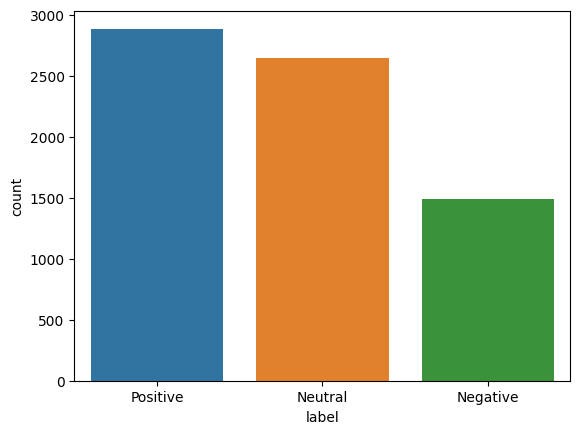

In [8]:
sns.countplot(data=df, x='label')

In [9]:
input_data = df['comment'].values
input_label = df['label'].values

label_dict = {'Positive':0,'Neutral':1,'Negative':2}

input_pre = []
label_with_accent = []
for i, cmt in enumerate(input_data):
    #tokenizes the text into a list of words and joins the list of words back into a single string, separated by spaces.
    input_text_pre = list(tf.keras.preprocessing.text.text_to_word_sequence(cmt))
    input_text_pre = ' '.join(input_text_pre)
    #remove accent and tokenize
    input_text_pre_no_accent = unidecode(input_text_pre)
    input_text_pre_no_accent = word_tokenize(input_text_pre_no_accent, format="text")
    #with accent and tokenize
    input_text_pre_accent = word_tokenize(input_text_pre, format="text")

    input_pre.append(input_text_pre_accent)
    input_pre.append(input_text_pre_no_accent)
    label_with_accent.append(input_label[i])
    label_with_accent.append(input_label[i])

<Axes: >

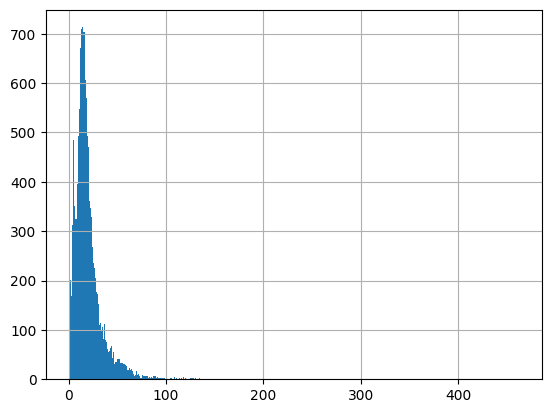

In [10]:
#Check sequence lenght
seq_len = [len(i.split()) for i in input_pre]
pd.Series(seq_len).hist(bins = max(seq_len))
#>>250

In [11]:
##--BUILD VOCAB--##
#create one-hot encoded vectors for label.
label_idx = [label_dict[i] for i in label_with_accent]
label_tf = tf.keras.utils.to_categorical(label_idx, num_classes = 3, dtype = 'float32')

#Tokenize and convert text data into sequences of numerical representations of the text data based on the tokenizer's vocabulary.
tokenizer_data = Tokenizer(oov_token = '<OOV>', split = ' ') #add out-of-vocab is tag '<OOV>'
tokenizer_data.fit_on_texts(input_pre)
tokenized_sequence = tokenizer_data.texts_to_sequences(input_pre)

#pad/truncate sequences to a fixed length (added to the end (right side) of the sequences).
vec_data = pad_sequences(tokenized_sequence, maxlen =250, padding = 'post')

#Save Vocab
pickle.dump(tokenizer_data, open('tokenizer_data.pkl', 'wb'))
#split data
vocab_size = len(tokenizer_data.word_index) + 1 #+1 for OOV
X_train_val, X_test, y_train_val, y_test = train_test_split(vec_data, label_tf, test_size = 0.1, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state = 42)
print('Vocab size: ',vocab_size)
print('Training data size: ', len(X_train))
print('Validation data size: ', len(X_val))
print('Testing data size: ', len(X_test))

Vocab size:  6527
Training data size:  10105
Validation data size:  2527
Testing data size:  1404


In [16]:
'''
Create model combining CNN and Bi-LSTM layers to leverages the strengths of both CNNs and LSTMs to improve the model's ability
to learn and extract features from text.
CNN are good at capturing local patterns/features while Bi-LSTM can capture information from both past and future context.
'''
def generate_model():
    input_dim = vocab_size
    output_dim = 30
    input_length = 250
    initializer = tf.keras.initializers.GlorotNormal()

    input_layer = Input(shape=(input_length,))

    embedding_layer = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length, embeddings_initializer=initializer)(input_layer)

    cnn = Conv1D(filters=30, kernel_size=3, padding='same', activation='relu')(embedding_layer)
    cnn = MaxPooling1D()(cnn) #feature selection, dimension reduction
    cnn = LayerNormalization()(cnn)
    cnn = Dropout(0.3)(cnn)

    bi_lstm = Bidirectional(LSTM(units=30, dropout=0.4, return_sequences=True, kernel_initializer=initializer))(embedding_layer)
    bi_lstm = MaxPooling1D()(bi_lstm)
    bi_lstm = LayerNormalization()(bi_lstm)
    bi_lstm = Dropout(0.3)(bi_lstm)

    output_layer = tf.keras.layers.Concatenate()([cnn, bi_lstm])
    output_layer = GlobalMaxPooling1D()(output_layer) #feature selection, dimension reduction
    output_layer = LayerNormalization()(output_layer)
    output_layer = Dropout(0.3)(output_layer)

    output_layer = Dense(40, activation='relu', kernel_regularizer=l2(0.01))(output_layer)
    output_layer = Dropout(0.3)(output_layer)
    output_layer = Dense(20, activation='relu', kernel_regularizer=l2(0.01))(output_layer)
    output_layer = Dropout(0.3)(output_layer)
    output_layer = Dense(3, activation='softmax', kernel_regularizer=l2(0.01))(output_layer)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

model = generate_model()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 250)]                0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 250, 30)              195810    ['input_2[0][0]']             
                                                                                                  
 conv1d_1 (Conv1D)           (None, 250, 30)              2730      ['embedding_1[0][0]']         
                                                                                                  
 bidirectional_1 (Bidirecti  (None, 250, 60)              14640     ['embedding_1[0][0]']         
 onal)                                                                                      

In [17]:
#ModelCheckpoint
checkpoint  = tf.keras.callbacks.ModelCheckpoint('model_cnn_bilstm.h5', monitor='val_loss')
early_stopping = EarlyStopping(
                              monitor='val_loss',  # Monitor validation loss
                              min_delta=0.001,      # Minimum change to be considered as an improvement
                              patience=3,           # Number of epochs with no improvement
                              mode='min',           # Minimize the monitored metric (loss)
                              restore_best_weights=True  # Restore model to the best state
                          )
reduce_lr = ReduceLROnPlateau(
                              monitor='val_loss'
                              ,factor=0.2
                              ,patience=3
                              ,min_lr=1e7
                              )
model.fit(x=X_train, y=y_train, validation_data=(X_val, y_val), epochs=20, batch_size=30 , callbacks=[checkpoint, early_stopping, reduce_lr ])

Epoch 1/20
337/337 [==============================] - 41s 105ms/step - loss: 1.5050 - accuracy: 0.4619 - val_loss: 1.0423 - val_accuracy: 0.6415 - lr: 0.0010
Epoch 2/20
337/337 [==============================] - 15s 44ms/step - loss: 0.9168 - accuracy: 0.6629 - val_loss: 0.7562 - val_accuracy: 0.7317 - lr: 0.0010
Epoch 3/20
337/337 [==============================] - 12s 35ms/step - loss: 0.7072 - accuracy: 0.7572 - val_loss: 0.6553 - val_accuracy: 0.7677 - lr: 0.0010
Epoch 4/20
337/337 [==============================] - 11s 33ms/step - loss: 0.6016 - accuracy: 0.8042 - val_loss: 0.6316 - val_accuracy: 0.7772 - lr: 0.0010
Epoch 5/20
337/337 [==============================] - 11s 31ms/step - loss: 0.5482 - accuracy: 0.8240 - val_loss: 0.6407 - val_accuracy: 0.7717 - lr: 0.0010
Epoch 6/20
337/337 [==============================] - 10s 28ms/step - loss: 0.4957 - accuracy: 0.8479 - val_loss: 0.6298 - val_accuracy: 0.7816 - lr: 0.0010
Epoch 7/20
337/337 [==============================] - 9s 

In [18]:
model.load_weights('model_cnn_bilstm.h5')
model.evaluate(X_test,y_test)

44/44 [==============================] - 1s 14ms/step - loss: 0.6232 - accuracy: 0.7813


[0.6231921911239624, 0.7813390493392944]

In [19]:
def pre_processing(raw_input, tokenizer):
    input_text_pre = cleaning(raw_input)
    input_text_pre = list(tf.keras.preprocessing.text.text_to_word_sequence(raw_input))
    input_text_pre = ' '.join(input_text_pre)
    input_text_pre_accent = word_tokenize(input_text_pre, format="text")
    #print('Text preprocessed: ',input_text_pre_accent)
    tokenized_text = tokenizer.texts_to_sequences([input_text_pre_accent])
    vec_data = pad_sequences(tokenized_text, padding='post', maxlen=250)
    return vec_data

def inference_model(input_vector, model):
    output = model(input_vector).numpy()[0]
    result = output.argmax()
    conf = float(output.argmax())
    label_dict = {'Positive':0,'Neutral':1,'Negative':2}
    label = list(label_dict.keys())
    return label[int(result)], conf

def prediction(raw_input, tokenizer, model):
    input_model = pre_processing(raw_input, tokenizer_data)
    result, conf = inference_model(input_model, model)
    return result

In [20]:
my_model = generate_model()
my_model = load_model('model_cnn_bilstm.h5')

with open('tokenizer_data.pkl', 'rb') as input_file:
    my_tokenizer = pickle.load(input_file)

df_Black_Rouge_Laz_Crawl = pd.read_csv('Black_Rouge_Laz_Crawl.csv')

df_Black_Rouge_Laz_Crawl['Comments_merge'] = df_Black_Rouge_Laz_Crawl['Comments'].fillna(df_Black_Rouge_Laz_Crawl['Comments_extra'])
df_Black_Rouge_Laz_Crawl['predicted_sentiment'] = df_Black_Rouge_Laz_Crawl['Comments_merge'].apply(lambda x: prediction(x, my_tokenizer, my_model))
df_Black_Rouge_Laz_Crawl

,User_name,Category,Comments,Comments_extra,Comments_merge,predicted_sentiment
0,Do Thi Thuyet,Màu : A05 - cam đỏ,NaN,Bình thường,Bình thường,Neutral
1,Ly Phạm,Màu : A06 - đỏ nâu,NaN,Hài lòng,Hài lòng,Positive
2,Tuyền Mèo,Màu : A11 - hồng cháy,NaN,Bình thường,Bình thường,Neutral
3,Bắp Bắp,Màu : A12 - nâu gạch,NaN,Hài lòng,Hài lòng,Positive
4,Dương Lê,Màu : A10 - đỏ berry,NaN,Rất không hài lòng,Rất không hài lòng,Negative
...,...,...,...,...,...,...
1856,Huyền Phạm,Màu : A12 - nâu gạch,đây là lần đầu tiên mik mua hàng ở tiki và rất...,Cực kì hài lòng,đây là lần đầu tiên mik mua hàng ở tiki và rất...,Positive
1857,Cao Thanh Nhàn,Màu : A15 - nâu ánh đỏ,sau khi nhận đc hàng thì hài lòng vô cùng ạ. ...,vé rì gút !!,sau khi nhận đc hàng thì hài lòng vô cùng ạ. ...,Neutral
1858,Nguyên Hương,Màu : A06 - đỏ nâu,Thất vọng thật sự. Muốn mua 1 thỏi son lì mà ...,Cực kì hài lòng,Thất vọng thật sự. Muốn mua 1 thỏi son lì mà ...,Negative
1859,Thảo Linh Travel,Màu : A01- đỏ dâu,"Ảnh mình chưa kịp chụp, lo test mã, và test c...",Cực kì hài lòng,"Ảnh mình chưa kịp chụp, lo test mã, và test c...",Positive


<Axes: xlabel='predicted_sentiment', ylabel='count'>

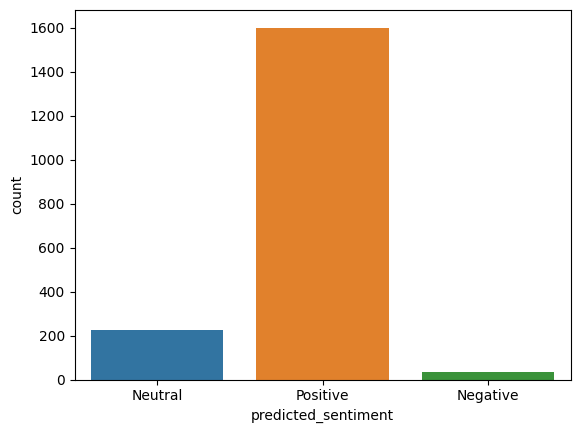

In [21]:
sns.countplot(data=df_Black_Rouge_Laz_Crawl, x='predicted_sentiment')